In [1]:
from __future__ import annotations

import os

os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'
os.environ['ARCHITECTURE'] = 'convnext'
os.environ['TILE_SIZE'] = '50'
os.environ['PRETRAINED'] = '1'
os.environ['OVERLAP'] = '25'
os.environ['BATCH_SIZE'] = '50'
os.environ['EXPERIMENTS_NAME'] = 'univariate'
os.environ['EPOCHS'] = '10'
os.environ['NUM_SAMPLES'] = '5'
os.environ['TRAIN_NUM_SAMPLES'] = '1000'
os.environ['OVERWRITE'] = '0'

In [2]:
import matplotlib.pyplot as plt
import ray
from ray.tune import Result

from landnet.config import CPUS, EXPERIMENTS_NAME, GPUS, MODELS_DIR, FIGURES_DIR
from landnet.enums import GeomorphometricalVariable
from landnet.logger import create_logger
from landnet.modelling import torch_clear
from landnet.modelling.classification.train import train_model
from landnet.modelling.tune import MetricSorter, get_results_df
from landnet.plots import ExperimentsResultPlot

if GPUS:
    torch_clear()

logger = create_logger(__name__)

if not ray.is_initialized():
    ray.init(num_cpus=CPUS, num_gpus=GPUS)

2025-11-16 12:09:17,649	INFO worker.py:1917 -- Started a local Ray instance.


# Configs

In [3]:
# used to only keep best checkpoint; if this does not work also try 'val_f2_score'
sorter = MetricSorter('val_f2_score', 'max')

# Train univariate models

In [4]:
results: list[Result] = []
for variable in GeomorphometricalVariable:
    logger.info('Tuning model with variable %s' % variable)
    best_result = train_model(
        variables=[variable],
        model_name=variable.value,
        sorter=sorter,
        out_dir=MODELS_DIR / EXPERIMENTS_NAME / variable.value,
    )
    results.append(best_result)

logger.info('Converting results to dataframe %s' % variable)
df = get_results_df(results, sorter, fix_missing_predictions=True)

df.to_csv(MODELS_DIR / EXPERIMENTS_NAME / 'results.csv', index=False)

INFO: Tuning model with variable GeomorphometricalVariable.SLOPE
INFO: Skipping training for [<GeomorphometricalVariable.SLOPE: 'slope'>] as /media/alex/alex/python-modules-packages-utils/landnet/models/univariate/slope already exists.
INFO: Tuning model with variable GeomorphometricalVariable.HILLSHADE
INFO: Skipping training for [<GeomorphometricalVariable.HILLSHADE: 'shade'>] as /media/alex/alex/python-modules-packages-utils/landnet/models/univariate/shade already exists.
INFO: Tuning model with variable GeomorphometricalVariable.TERRAIN_RUGGEDNESS_INDEX
INFO: Skipping training for [<GeomorphometricalVariable.TERRAIN_RUGGEDNESS_INDEX: 'tri'>] as /media/alex/alex/python-modules-packages-utils/landnet/models/univariate/tri already exists.
INFO: Tuning model with variable GeomorphometricalVariable.POSITIVE_TOPOGRAPHIC_OPENNESS
INFO: Skipping training for [<GeomorphometricalVariable.POSITIVE_TOPOGRAPHIC_OPENNESS: 'poso'>] as /media/alex/alex/python-modules-packages-utils/landnet/models/

# Plots

In [5]:
plots = ExperimentsResultPlot(df)

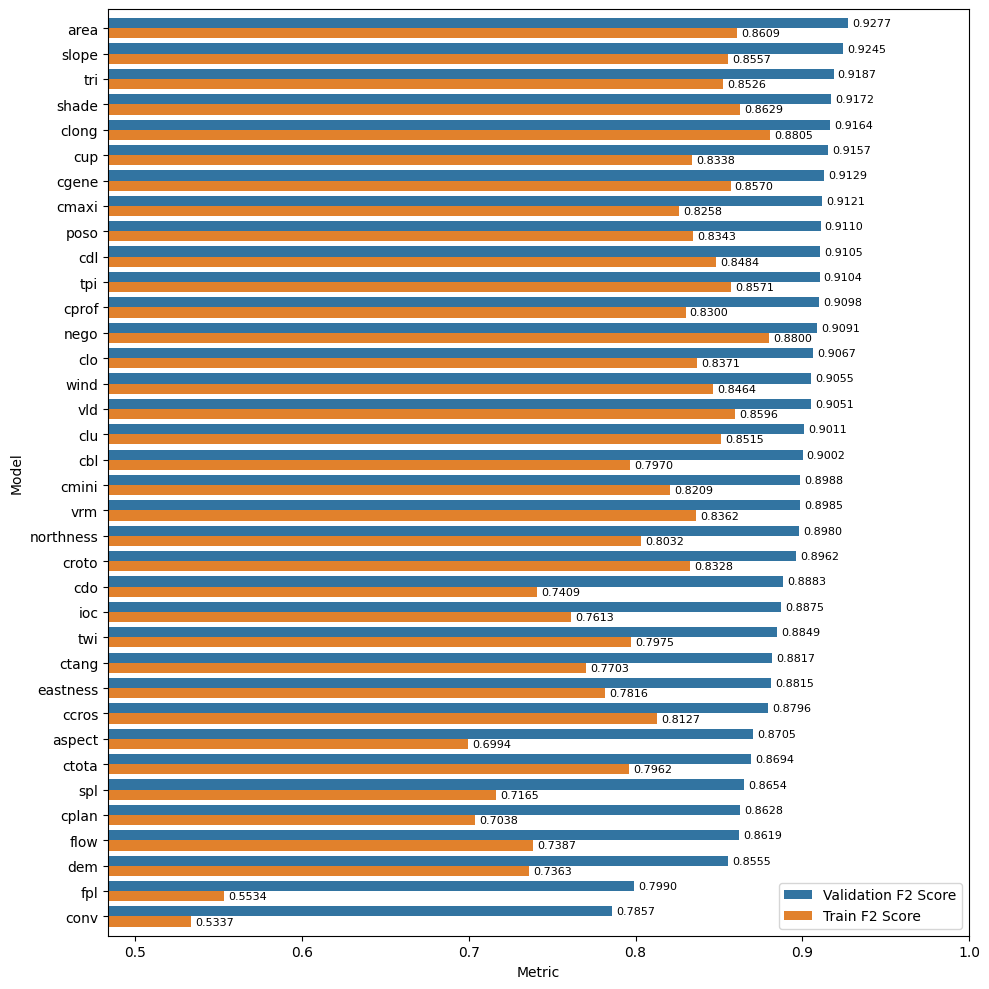

In [6]:
fig, ax = plt.subplots(figsize=(10, 10))
plots.model_bar_plot(
    value_vars=['validation_f2_score', 'train_f2_score'], ax=ax
)
fig.savefig(FIGURES_DIR / 'univariate_f2_score.png', dpi=300)